In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error

## 1. 데이터 불러오기(상관분석 X)

In [4]:
df_filtered=pd.read_excel('데이터1_독립변수전체_24추가.xlsx')

df_filtered

,판매일,판매수량,가공식품류,경제성장률(실질GDP성장률),"과자,씨리얼,초코릿,빵류",기준금리,남성 실업률,"라면,통조림,상온즉석",명절세트(비식품),명절세트(식품),...,양곡,여성 실업률,잡화,전체 실업률,총 발주건수,"축산,수산,건해산","커피,차류",평균 발주 일자,"헤어,바디,구강",화장지류
0,2021-01-04,1039,0.698113,2.5,0.679245,0.5,5.0,1,0,0,...,0,6.7,0.547170,5.7,384.000000,0,0.000000,3.298969,0,0
1,2021-01-05,3502,0.666667,2.5,0.586207,0.5,5.0,1,0,0,...,0,6.7,0.735632,5.7,316.843648,0,0.540230,3.977850,0,0
2,2021-01-12,4037,0.721154,2.5,0.855769,0.5,5.0,1,0,0,...,0,6.7,0.682692,5.7,327.749311,0,0.000000,5.476309,0,0
3,2021-01-19,3023,0.736842,2.5,0.757895,0.5,5.0,1,0,0,...,0,6.7,0.726316,5.7,334.207921,0,0.505263,4.533993,0,0
4,2021-01-26,2621,0.792683,2.5,0.743902,0.5,5.0,1,0,0,...,0,6.7,0.682927,5.7,377.821577,0,0.548780,4.828216,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,2024-05-28 00:00:00,3463,0.757895,2.3,0.736842,3.5,3.1,1,0,0,...,0,2.7,0.778947,3.0,381.533898,0,0.505263,3.673446,0,0
179,2024-06-04 00:00:00,2538,0.744444,2.3,0.711111,3.5,3.0,1,0,0,...,0,2.8,0.811111,2.9,362.042763,0,0.000000,3.941447,0,0
180,2024-06-11 00:00:00,3130,0.786517,2.3,0.797753,3.5,3.0,1,0,0,...,0,2.8,0.820225,2.9,387.078488,0,0.000000,3.634593,0,0
181,2024-06-18 00:00:00,2704,0.654762,2.3,0.773810,3.5,3.0,1,0,0,...,0,2.8,0.738095,2.9,391.024922,0,0.000000,3.542368,0,0


In [5]:
#데이터셋 변수 확인
print(df_filtered.columns.tolist())

['판매일', '판매수량', '가공식품류', '경제성장률(실질GDP성장률)', '과자,씨리얼,초코릿,빵류', '기준금리', '남성 실업률', '라면,통조림,상온즉석', '명절세트(비식품)', '명절세트(식품)', '방향제류', '생수,음료,건강', '생활물가지수', '세제류', '소비자물가지수', '소비자심리지수', '신선식품', '양곡', '여성 실업률', '잡화', '전체 실업률', '총 발주건수', '축산,수산,건해산', '커피,차류', '평균 발주 일자', '헤어,바디,구강', '화장지류']


## 2. 변수 설정 및 스케일링

In [6]:
# 판매일 인덱스 처리
df = df_filtered.copy()
df['판매일'] = pd.to_datetime(df['판매일'])

df.set_index('판매일', inplace=True)

# 독립변수, 종속 변수 지정
X = df.drop(columns=['판매수량'])
y = df['판매수량']

# 독립변수 스케일링
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

## 3. 시퀀스 데이터 생성 및 데이터 분할

In [7]:
# 시계열 데이터 예측을 위한 생성 함수
def create_sequences(X, y, time_steps=4):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# 시퀀스 데이터 생성 (4주 단위)
time_steps = 4
X_seq, y_seq = create_sequences(X_scaled, y.values, time_steps)

In [8]:
# 학습 데이터와 테스트 데이터 분리 (2024년 1월 이전까지는 학습, 이후는 테스트)
split_index = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_index], X_seq[split_index:]
y_train, y_test = y_seq[:split_index], y_seq[split_index:]

## 4. 모델 함수 생성

In [9]:
# LSTM 모델 구축
def build_lstm_model(units=50):
    model = Sequential()
    model.add(LSTM(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# GRU 모델 구축
def build_gru_model(units=50):
    model = Sequential()
    model.add(GRU(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

## 5. 모델 학습 및 성능 평가

In [10]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    return y_pred, rmse, mae

# LSTM 모델 학습 및 평가
lstm_model = build_lstm_model()
y_pred_lstm, rmse_lstm, mae_lstm = train_and_evaluate_model(lstm_model, X_train, y_train, X_test, y_test)

# GRU 모델 학습 및 평가
gru_model = build_gru_model()
y_pred_gru, rmse_gru, mae_gru = train_and_evaluate_model(gru_model, X_train, y_train, X_test, y_test)

print(f"LSTM RMSE: {rmse_lstm}, MAE: {mae_lstm}")
print(f"GRU RMSE: {rmse_gru}, MAE: {mae_gru}")

/Users/kook/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/Users/kook/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
LSTM RMSE: 826.4291333916696, MAE: 740.6155870225695
GRU RMSE: 772.8131400498402, MAE: 700.9227227105034


## 6. 마무리

In [15]:
# 판매일 인덱스 생성
pred_dates = df.index[-len(y_test):]  # 테스트 데이터의 판매일 인덱스

# 실제값, LSTM 예측값, GRU 예측값으로 데이터프레임 생성
results = pd.DataFrame({
    '판매일': pred_dates,
    '실제값': y_test,
    'GRU 예측값': y_pred_gru.flatten(),
    'LSTM 예측값': y_pred_lstm.flatten()    
})

# 인덱스를 판매일로 설정
results.set_index('판매일', inplace=True)

# 결과 데이터프레임 출력
results

,실제값,GRU 예측값,LSTM 예측값
판매일,,,
2023-10-24,2726,2861.187988,2734.959961
2023-10-31,2904,3064.364258,3032.055908
2023-11-07,2816,3092.722656,3061.721680
2023-11-14,2988,3069.491455,3008.991943
2023-11-21,2543,3154.736816,3133.046143
2023-11-28,2559,3560.581299,3652.123779
2023-12-05,2643,3483.685791,3543.261230
2023-12-12,2991,3508.611328,3581.490234
2023-12-19,2391,3251.990479,3270.319824


In [16]:
results = results.reset_index()

results

,판매일,실제값,GRU 예측값,LSTM 예측값
0,2023-10-24,2726,2861.187988,2734.959961
1,2023-10-31,2904,3064.364258,3032.055908
2,2023-11-07,2816,3092.722656,3061.721680
3,2023-11-14,2988,3069.491455,3008.991943
4,2023-11-21,2543,3154.736816,3133.046143
5,2023-11-28,2559,3560.581299,3652.123779
6,2023-12-05,2643,3483.685791,3543.261230
7,2023-12-12,2991,3508.611328,3581.490234
8,2023-12-19,2391,3251.990479,3270.319824
9,2023-12-26,2605,3311.415527,3329.936523


In [17]:
# 2024년도 데이터만 필터링
results_2024 = results[results['판매일'].dt.year == 2024]

# 월별로 그룹화하고 합산
monthly_sales = results_2024.resample('M', on='판매일').sum().reset_index()

# 'index' 칼럼 삭제
monthly_sales = monthly_sales.drop(columns=['index'], errors='ignore')

monthly_sales

/var/folders/4q/g67ctnjs2n1b934mldw6ktyr0000gn/T/ipykernel_4417/2854464769.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = results_2024.resample('M', on='판매일').sum().reset_index()


,판매일,실제값,GRU 예측값,LSTM 예측값
0,2024-01-31,13893,17665.380859,18024.990234
1,2024-02-29,11203,14423.778320,14667.341797
2,2024-03-31,11487,14430.361328,14660.949219
3,2024-04-30,13748,17547.830078,17762.513672
4,2024-05-31,11501,13987.624023,14184.575195
5,2024-06-30,11346,14371.171875,14698.484375


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
/var/folders/4q/g67ctnjs2n1b934mldw6ktyr0000gn/T/ipykernel_4417/620690812.py:17: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  plt.tight_layout()
/var/folders/4q/g67ctnjs2n1b934mldw6ktyr0000gn/T/ipykernel_4417/620690812.py:17: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  plt.tight_layout()
/var/folders/4q/g67ctnjs2n1b934mldw6ktyr0000gn/T/ipykernel_4417/620690812.py:17: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  plt.tight_layout()
findfont: Font family 'Malgun Gothic' not found.
findfont: Font famil

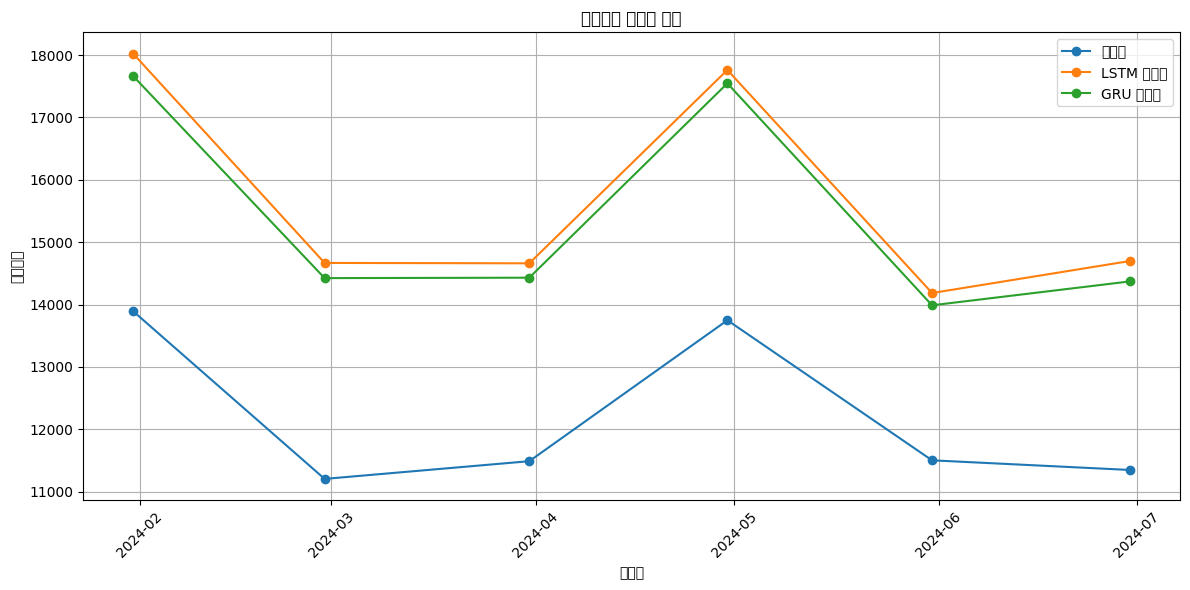

In [14]:
import matplotlib.font_manager as fm

plt.rc('font', family='Malgun Gothic')

#라인 차트 시각화
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['판매일'], monthly_sales['실제값'], marker='o', label='실제값')
plt.plot(monthly_sales['판매일'], monthly_sales['LSTM 예측값'], marker='o', label='LSTM 예측값')
plt.plot(monthly_sales['판매일'], monthly_sales['GRU 예측값'], marker='o', label='GRU 예측값')

plt.title('실제값과 예측값 비교')
plt.xlabel('판매일')
plt.ylabel('판매수량')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()